In [1]:
import os
from PIL import Image

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
from torch import optim

In [2]:
print(torch.__version__)

1.2.0


In [3]:
data_dir = "dataset/"

In [4]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 128
# percentage of the data used for training, validation and test set
valid_size  = 0.25
test_size   = 0.10
train_size  = 0.75

# Load the dataset

In [5]:
transform_train = transforms.Compose([
    transforms.Resize(36),
    transforms.CenterCrop(32),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

# Validation don't use data augmentation (RandomHorizontalFlip, RandomRotation)
transform_validation_test = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define transforms used for the training and validation sets
data_transforms = [transform_train, transform_validation_test]

# Load the datases with ImageFolder (NOTE: if everything goes wrong this is the problem)
data = datasets.ImageFolder(data_dir, transform=data_transforms[0])

# Obtain training indices that will be used for validation
len_data = len(data)
indices = list(range(len_data))
np.random.shuffle(indices)

split1 = int(np.floor(valid_size * len_data)) # end validation
split2 = int(np.floor((valid_size * len_data) + (test_size * len_data))) # end test

# Get the indexes for each split
valid_idx, test_idx, train_idx = indices[:split1], indices[split1:split2], indices[split2:len_data]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
    sampler=test_sampler, num_workers=num_workers)

In [6]:
# helper function to un-normalize an image
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

# helper function to display an image
def imshow(img):
    img = torch.tensor(img)
    unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    img = unorm(img)
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# Classes in the dataset

In [7]:
import json

# Get classes names
classes = {}
for index, name in enumerate(data.classes):
    classes[index] = name
    
# Save to JSON
with open('labels_to_class_names.json', 'w', encoding='utf-8') as file:
    json.dump(classes, file, ensure_ascii=False, indent=4)

# Show classes
classes

{0: 'bicycle',
 1: 'bus',
 2: 'car',
 3: 'motorcycle',
 4: 'pickuptruck',
 5: 'truck',
 6: 'van'}

# Visualization of the classes

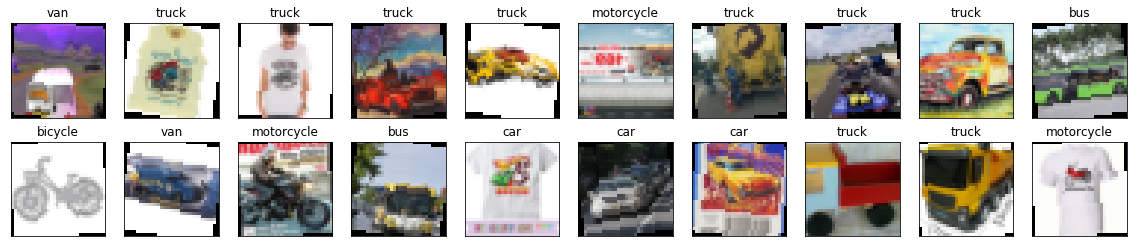

In [8]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images, labels = images.numpy(), labels.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

# Building Classifier

In [9]:
from model import Net
    
model = Net()
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=7, bias=True)
  (dropout50): Dropout(p=0.5, inplace=False)
)

In [10]:
# Specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

# Training the classifier

In [11]:
train_on_gpu = torch.cuda.is_available()
model.class_to_idx = data.class_to_idx

# number of epochs to train the model
n_epochs = 100
#train_on_gpu = False
valid_loss_min = np.Inf # track change in validation loss
if(train_on_gpu):
    model.cuda()
else:
    model.cpu()

for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        state = {'model_version': '1', 'epoch': epoch, 'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict(), 'valid_loss': valid_loss, 
                'criterion': criterion, 'class_to_idx': model.class_to_idx, 'labels_map': classes}
        torch.save(state, 'best_model.pt')
        valid_loss_min = valid_loss
    print("")

Epoch: 1 	Training Loss: 1.099304 	Validation Loss: 0.381004
Validation loss decreased (inf --> 0.381004).  Saving model ...

Epoch: 2 	Training Loss: 1.011321 	Validation Loss: 0.373672
Validation loss decreased (0.381004 --> 0.373672).  Saving model ...

Epoch: 3 	Training Loss: 1.002590 	Validation Loss: 0.369820
Validation loss decreased (0.373672 --> 0.369820).  Saving model ...

Epoch: 4 	Training Loss: 0.985721 	Validation Loss: 0.363530
Validation loss decreased (0.369820 --> 0.363530).  Saving model ...

Epoch: 5 	Training Loss: 0.963609 	Validation Loss: 0.365028

Epoch: 6 	Training Loss: 0.960197 	Validation Loss: 0.360709
Validation loss decreased (0.363530 --> 0.360709).  Saving model ...

Epoch: 7 	Training Loss: 0.936639 	Validation Loss: 0.353139
Validation loss decreased (0.360709 --> 0.353139).  Saving model ...

Epoch: 8 	Training Loss: 0.918850 	Validation Loss: 0.348012
Validation loss decreased (0.353139 --> 0.348012).  Saving model ...

Epoch: 9 	Training Loss: 0